# Purpose

In this Notebook, we will put together all of the data we have collected so far, and get more mature customer segments using KMeans.

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd  # For processing and IO

import datetime as dt

from sklearn.preprocessing import (
    Normalizer, StandardScaler
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

from matplotlib import pyplot as plt
%matplotlib inline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# We initiate random seeds for algorithms
KM_RANDOM_SEED=42
PCA_RANDOM_SEED=7

In [14]:
def round_time(
    dt1: dt.datetime, 
    dt2: dt.datetime, 
    round_to: str = '1d'
) -> dt.timedelta:
    """
    Returns a rounded timedelta from two datetime objects.
    dt1 and dt2 should be two datetime objects.
    """
    return (dt1 - dt2).round(round_to)


def perform_kmeans(df: pd.DataFrame, n_clusters: int) -> np.array:
    """
    Small helper function to perform KMeans with a set number of
    clusters.
    
    Returns the clusters from KMeans.
    """
    # We create the clusters
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=KM_RANDOM_SEED
    )
    kmeans.fit(df)

    return kmeans.labels_
    

def plot_kmeans(df: pd.DataFrame, ax = None):
    """
    Plots the clusters from k-means (data is reduced to 
    2 dimensions using PCA).
    """
    # We decompose the data
    decomp = PCA(
        2, 
        random_state=PCA_RANDOM_SEED
    ).fit_transform(df)
    
    unique_labels = np.unique(df['cluster'])
    
    if not ax:
        _, ax = plt.subplots()
    for lbl in unique_labels:
        ax.scatter(
            decomp[df['cluster'] == lbl, 0], 
            decomp[df['cluster'] == lbl, 1],
            s=2.5,
            label = f'Cluster {lbl+1}'
        )
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


def analyse_clusters(data: pd.DataFrame) -> pd.DataFrame:
    """
    Analyses the clustered data. Returns agregated dataframe.
    """
    # Averages for each column
    aggr = data.groupby('cluster').mean()
    
    # And the number of members in each cohort
    aggr = pd.concat(
        [
            aggr, 
            data.groupby('cluster').size()
        ], 
        axis=1
    ).rename(columns={0: 'cohort_size'})
    
    return aggr

In [19]:
# This should be familiar now
# We load the relevant datasets
apps_gensim = pd.read_json(
    '../data/processed/apps_with_genresim.json'
)
apps_gensim['release_date__dt'] = pd.to_datetime(
    apps_gensim['release_date__date'], 
    format='%b %d, %Y',
    utc=True
)

apps_descsim = pd.read_json(
    '../data/processed/apps_with_descrsim.json'
)

users = pd.read_csv(
    '../data/raw/purchase_data.csv',
    parse_dates=['timestamp_purchased']
)

users_rf = pd.read_json(
    '../data/processed/simple_userRF.json'
)

In [20]:
# We get the complete details of all games
full_apps = pd.merge(
    apps_gensim,
    apps_descsim,
    on='appid'
)
display(full_apps.sample(5))

,appid,name,release_date__date,genre_description,categories_description,short_description,about_the_game,genre_sim_NieR,release_date__dt,descr_sim_NieR
76,211740,Thief 2,"May 22, 2012","Action,Simulation",Single-player,None,The ultimate thief is back! Tread softly as yo...,0.250000,2012-05-22 00:00:00+00:00,0.259532
38,28000,Kane & Lynch 2: Dog Days,"Aug 17, 2010",Action,"Co-op,Multi-player,Single-player,Steam Achieve...",Pure adrenaline of non-stop action in Single P...,Play as two of gaming's most disturbing and re...,0.333333,2010-08-17 00:00:00+00:00,0.171990
69,225000,Tomb Raider: Chronicles,"Nov 28, 2012","Action,Adventure",Single-player,None,Lara Croft is missing in Egypt - presumed dead...,0.250000,2012-11-28 00:00:00+00:00,0.040922
8,225540,Just Cause 3,"Nov 30, 2015","Action,Adventure","Full controller support,Single-player,Steam Ac...",With over 1000 km² of complete freedom from sk...,"<img src=""https://steamcdn-a.akamaihd.net/stea...",0.250000,2015-11-30 00:00:00+00:00,0.127243
34,39140,FINAL FANTASY VII,"Jul 4, 2013",RPG,"Partial Controller Support,Single-player,Steam...",None,"In Midgar, a city controlled by the mega-congl...",0.333333,2013-07-04 00:00:00+00:00,0.120346


In [21]:
# Now we do a full merge to get the days since release (see Part 4)
full_data = pd.merge(
    users,
    full_apps,
    on='appid'
)
display(full_data.sample(5))
print(full_data.shape)

,userid,appid,timestamp_purchased,name,release_date__date,genre_description,categories_description,short_description,about_the_game,genre_sim_NieR,release_date__dt,descr_sim_NieR
116368,5ec82ae262e3144cb090eaa8071ae45fdc3b6259176926...,39160,2014-12-24 05:54:58.554344+00:00,Dungeon Siege III,"Jun 20, 2011","Action,RPG","Co-op,Multi-player,Single-player,Steam Achieve...",Fight hordes of dangerous creatures in a mysti...,For centuries legionnaires have protected the ...,0.666667,2011-06-20 00:00:00+00:00,0.171787
20832,06036ab2b124fea878c8d0d50899cd59741fb86e4d14b3...,292120,2014-10-10 02:35:31.554344+00:00,FINAL FANTASY XIII,"Oct 9, 2014",RPG,"Partial Controller Support,Single-player,Steam...",Final Fantasy XIII is a fantasy RPG in which a...,DO YOU HAVE THE COURAGE TO FACE YOUR DESTINY?<...,0.333333,2014-10-09 00:00:00+00:00,0.301402
73614,3657a2258a5bfe0aa6704b9e28f989009fe915f62abc45...,203160,2014-06-23 02:04:51.554344+00:00,Tomb Raider,"Mar 4, 2013","Action,Adventure","Full controller support,Multi-player,Single-pl...",Tomb Raider explores the intense origin story ...,"<img src=""https://steamcdn-a.akamaihd.net/stea...",0.250000,2013-03-04 00:00:00+00:00,0.085277
78218,09b53a6a9b9024d3e077a99934f38162c1c5942297c434...,203160,2014-06-21 21:43:34.554344+00:00,Tomb Raider,"Mar 4, 2013","Action,Adventure","Full controller support,Multi-player,Single-pl...",Tomb Raider explores the intense origin story ...,"<img src=""https://steamcdn-a.akamaihd.net/stea...",0.250000,2013-03-04 00:00:00+00:00,0.085277
120293,dcd8d1852703965d9bcde3c20a5be1e8bd6c3ecc7d8116...,8190,2014-11-13 03:31:19.554344+00:00,Just Cause 2,"Mar 23, 2010","Action,Adventure","Full controller support,Single-player,Steam Ac...",Dive into an adrenaline-fuelled free-roaming a...,Dive into an adrenaline-fuelled free-roaming a...,0.250000,2010-03-23 00:00:00+00:00,0.145424


(133525, 12)


In [22]:
full_data['time_between_purchase_release'] = full_data[
    [
        'release_date__dt', 
        'timestamp_purchased'
    ]
].apply(
    lambda dts: round_time(dts[1], dts[0]).days,
    axis=1
)

# We'll correct for the shortcomings of our round_time
# function by replacing values with 0 if the date of purchase
# and the date of release is the same
indeces = full_data[
    full_data['release_date__dt'].dt.date == full_data['timestamp_purchased'].dt.date
].index.tolist()

full_data.loc[indeces, 'time_between_purchase_release'] = 0

We aggregate the data to user, and get the relevant averages.

In [23]:
full_data = pd.merge(
    full_data.groupby(
        'userid',
        as_index=False
    ).aggregate(
        {
            'genre_sim_NieR': np.nanmean,
            'time_between_purchase_release': np.nanmean,
            'descr_sim_NieR': np.nanmean
        }
    )
    ,
    users_rf,
    on='userid'
)
display(full_data.sample(5))

,userid,genre_sim_NieR,time_between_purchase_release,descr_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016
87783,c46da63a44a96c33d1cdb42d6f9958692d3ce283a8c916...,0.333333,8.0,0.301402,865,0,1,0,0
73101,a3e61dc4ed0618fb33b88a3eee5cb4728944bded708264...,0.500000,381.0,0.194805,620,0,0,1,0
53624,77a97437317d7ca2d41a79fffbd6a5aa19399f58f37046...,0.000000,1885.0,0.256264,95,0,0,0,1
78741,b07493f5b06e9fce5f642c08153587c9ed73dc8ac9054e...,0.333333,941.0,0.120346,394,0,0,0,1
103113,e6af1dd1ef21de597c336006c850c6f74b63487fe8713e...,0.250000,1038.0,0.085277,419,0,0,0,1


Now that we have all of the data, we can begin to preprocess and cluster.

### Preprocessing

In [24]:
full_data['user_recency_sr'] = np.sqrt(full_data['user_recency'])
full_data['time_between_purchase_release_cr'] = np.cbrt(
    full_data['time_between_purchase_release']
)

In [25]:
# And standardise, as we did before
scaler = StandardScaler()

full_data_standardised = full_data.copy(deep=True)

cols_to_std = [
    'genre_sim_NieR',
    'user_recency_sr',
    'user_frequency_2013',
    'user_frequency_2014', 
    'user_frequency_2015', 
    'user_frequency_2016',
    'time_between_purchase_release_cr',
    'descr_sim_NieR'
]

for col in cols_to_std:
    scaler = StandardScaler()
    full_data_standardised[
        f'{col}_std'
    ] = scaler.fit_transform(
        full_data_standardised[col].values.reshape(-1, 1)
    )

for_kmeans = full_data_standardised.set_index(
    'userid' # we no longer need the userid column, 
).filter(
    regex='_std' # To keep every standardised column
)
display(for_kmeans.head())

,genre_sim_NieR_std,user_recency_sr_std,user_frequency_2013_std,user_frequency_2014_std,user_frequency_2015_std,user_frequency_2016_std,time_between_purchase_release_cr_std,descr_sim_NieR_std
userid,,,,,,,,
00002eaf0b53c394391f96a5cae5023ef8ae704797880bb97b1a78eb0c6eb05a,2.368959,-0.943674,-0.319101,-0.550962,-0.523706,0.694216,-1.401068,-0.660406
00015d3d8ae55e47cc0bf2d964ea7f6a3f4ac65239abe280dd1adb8b143e3ff1,-0.403591,1.793497,2.391075,-0.550962,-0.523706,-0.741147,-1.687781,-0.978131
000364b1cefaf76b3abf76080595936a32de847e908ee70cf0ac25cff96b6fe0,2.368959,-0.906819,-0.319101,-0.550962,-0.523706,0.694216,-1.601753,-0.660406
00048a2093a1786989d15a4855ba1c3511c02e4c9210940b1a4fa83b0831c967,-0.403591,-0.264197,-0.319101,-0.550962,-0.523706,0.694216,-1.516236,-0.005827
0004f2043ce240448a1f508cee1413730a207f8dabdd2c10812ca4e32169f01c,2.368959,-0.939533,-0.319101,-0.550962,-0.523706,0.694216,-1.417331,-0.660406


### Clustering

Now we can perform the same steps as we did in the previous Notebooks.

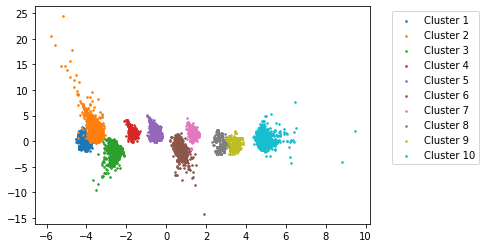

In [26]:
for_kmeans['cluster'] = perform_kmeans(for_kmeans, 10)
plot_kmeans(for_kmeans)

We will again skip a few steps, and fix the number of clusters at 10,

In [27]:
full_data['cluster'] = perform_kmeans(for_kmeans, 10)
analyse_clusters(
    full_data.drop(
        ['user_recency_sr', 'time_between_purchase_release_cr'], 
        axis=1
    )
)

,genre_sim_NieR,time_between_purchase_release,descr_sim_NieR,user_recency,user_frequency_2013,user_frequency_2014,user_frequency_2015,user_frequency_2016,cohort_size
cluster,,,,,,,,,
0,0.253207,1355.019391,0.127177,170.482432,0.009482,0.029289,0.035347,1.124691,18983
1,0.529408,215.025644,0.265396,826.466365,0.006864,0.782125,0.306288,0.014552,7284
2,0.426638,1032.933805,0.268098,188.615828,0.017396,0.064437,0.126302,1.468210,8163
3,0.262224,781.745272,0.122427,949.560807,0.008608,1.147488,0.030806,0.024112,19866
4,0.270787,1221.587769,0.127623,582.459531,0.005626,0.053891,1.220580,0.083379,14752
5,0.279454,645.885288,0.144169,1168.581719,1.111765,0.081900,0.055928,0.047964,11050
6,0.649784,53.613256,0.117114,149.768904,0.012286,0.035688,0.038613,1.087026,6837
7,0.253081,120.737340,0.162557,259.125726,0.007357,0.023615,0.012727,1.050835,13593
8,0.305590,144.533284,0.190167,521.696096,0.003972,0.027916,1.079891,0.078643,8812


We have introduced yet another metric with which to classify our customers. However, it does not seem to add much information, considering the similarity between these and the previous clusters. Maybe if we increase the number of clusters, the effect of description similarity might be more pronouced.

Interestingly, we still see the large contigency of customers with relatively low recency statistics, but high time between purchase and release (cluster 0), indicating that these customers are grouped regardless. We should aim to investigate this cluster more!

### Final thoughts

Over the last 6 Notebooks, we perfomed a (relatively) complete clustering exercise, the purpose of which was to segment customers based on standard metrics, and then we supplemented the clustering with more data. We aimed at finding segments of our customer base that would likely purchase a specific game (NieR), based on their frequency of purchase, recency of purchase, how long it took them to buy a game after it's release, how similar a game is to NieR based on it's genres, and how similar it is to NieR based on it's description.

We found that, in every instance, we can find segments of our customer base that is very likely going to purchase NieR, based on their purchasing habits (having bought games with a high genre similarity to NieR). We also find segments that contains customers that have likely churned, which we'd need to confirm with stakeholders. Interestingly, we found a persistent cluster of customers that warrant more analysis (low recency, high time between release and purchase) for their value later in a game's life.

#### Ideas for improving

A few ideas to improve these clusters include:

 - more granular clustering, i.e. setting a higher number of clusters when instantiating KMeans
 - explicitly representing DLCs in the data we use for clustering, which will help identify users who just buy base games vs users who tend to buy DLCs and other special editions
 - using different hyperparamters when generating description similarities, e.g. using different stemmers
 - use of additional data, such as cost for each transaction, whether the user purchased a game during a sale period, whether the transaction was part of a bundle, which should allow us to create even more descriptive customer profiles
 - use of fewer features when clustering data, which might make clustering and describing the results more complex than necessary
 - use of different clustering algorithms, such as DBSCAN or Agglomerative Clustering, which are not as restrictive with how data is input to the algorithm
   - different clustering algorithms would come with different hyperparameters to optimise, which is part of the attractiveness of KMeans (only one hyperparameter to optimise: the number of clusters)